<a href="https://colab.research.google.com/github/zzo14/DATA301/blob/main/301_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#library and code setup
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark

import pyspark, os
from pyspark import SparkConf, SparkContext
os.environ["PYSPARK_PYTHON"]="python3"
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64/"

!pip install gdelt

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,414 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packa

In [ ]:
#start spark local server
import sys, os
from operator import add
import time

os.environ["PYSPARK_PYTHON"]="python3"

import pyspark
from pyspark import SparkConf, SparkContext

#connects our python driver to a local Spark JVM running on the Google Colab server virtual machine
try:
  conf = SparkConf().setMaster("local[*]").set("spark.executor.memory", "1g")
  sc = SparkContext(conf = conf)
except ValueError:
  #it's ok if the server is already started
  pass

def dbg(x):
  """ A helper function to print debugging information on RDDs """
  if isinstance(x, pyspark.RDD):
    print([(t[0], list(t[1]) if 
            isinstance(t[1], pyspark.resultiterable.ResultIterable) else t[1])
           if isinstance(t, tuple) else t
           for t in x.take(100)])
  else:
    print(x)

In [ ]:
# these remove files from previous runs
!rm -rf articles
!rm *.csv

rm: cannot remove '*.csv': No such file or directory


In [ ]:
queryURLbase = "https://api.gdeltproject.org/api/v2/doc/doc?format=csv&query=(%22Covid-19%22%20OR%20coronavirus)%20sourcecountry:US%20sourcelang:eng&mode=artlist&maxrecords=250&sort=hybridrel"

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from datetime import date, timedelta
import pandas as pd
import gdelt
import os
import urllib.request

# set up gdeltpyr for version 2
gd = gdelt.gdelt(version=2)

# multiprocess the query
e = ProcessPoolExecutor()


# generic functions to pull and write data to disk based on date
def get_filename(x):
  date = x.strftime('%Y%m%d')
  return "{}_gdeltdata.csv".format(date)

def intofile(filename):
    try:
        if not os.path.exists(filename):
          date = filename.split("_")[0]
          startdate = date+"000000" #0 hour 0 min 0 sec (start of day)
          enddate = date+"235959" #23 hour 59 min 59 sec (end of day)
          query = queryURLbase + "&startdatetime=" + startdate + "&enddatetime=" + enddate
          with urllib.request.urlopen(query) as testfile, open(filename, 'w') as f:
            f.write(testfile.read().decode())
    except:
        print("Error occurred")
        
before_election_dateRange = sc.parallelize(pd.date_range('2020 Aug 3','2020 Nov 3'))
after_election__dateRange = sc.parallelize(pd.date_range('2021 Jan 20', '2021 Apr 20'))

before_election = before_election_dateRange.map(get_filename)
after_election = after_election__dateRange.map(get_filename)

before_election.foreach(intofile)
after_election.foreach(intofile)

In [ ]:
start_time = time.time()

In [ ]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

before_election_urls = sqlContext.read.option("header", "true").csv(before_election.collect()).dropDuplicates(['Title'])
after_election_urls = sqlContext.read.option("header", "true").csv(after_election.collect()).dropDuplicates(['Title'])

dbg(before_election_urls.count())
dbg(after_election_urls.count())

14978
13324


In [ ]:
import time
from datetime import datetime
from pyspark.sql.functions import month
from pyspark.sql.types import DateType

def get_headlines(row):
    return row['Title']

       
all_headlines_before = before_election_urls.rdd.map(get_headlines)
all_headlines_after = after_election_urls.rdd.map(get_headlines)

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

sia = SentimentIntensityAnalyzer()
results = []
headlines = [all_headlines_before.collect(), all_headlines_after.collect()]
months_before = before_election_urls.select(month(before_election_urls.Date)).rdd.flatMap(lambda x: x).collect()
months_after = after_election_urls.select(month(after_election_urls.Date)).rdd.flatMap(lambda x: x).collect()
dates = [months_before, months_after]

for head,date in zip(headlines,dates):
  #print(head, date)
  if len(results)!=0:
    df=pd.DataFrame(results)
    df['label'] = 0
    df.loc[df['compound'] > 0.2, 'label'] = 1
    df.loc[df['compound'] < -0.2, 'label'] = -1
    df.to_csv('before_sia.csv')
    results=[]
  for line,dt in zip(head,date) :
    try:
      pol_score = sia.polarity_scores(line)
      pol_score['headline'] = line
      pol_score['month']=dt
      results.append(pol_score)
    except:
      print('Skipped')

df = pd.DataFrame(results)
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1
df.to_csv('after_sia.csv')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
before_sentiments = sqlContext.read.option("header", "true").csv('before_sia.csv')
after_sentiments = sqlContext.read.option("header", "true").csv('after_sia.csv')

In [ ]:
before_sentiments.groupby('month').agg({'compound': 'mean'}).show()

+-----+--------------------+
|month|       avg(compound)|
+-----+--------------------+
|   11|-0.04194635294117...|
|    8|-0.02410667074663...|
|    9|-0.02800129353233...|
|   10|-0.00773623000432...|
+-----+--------------------+



In [ ]:
after_sentiments.groupby('month',sortBy=True).agg({'compound': 'mean'}).show()

+-----+--------------------+
|month|       avg(compound)|
+-----+--------------------+
|    3|-0.02214569591371098|
|    1| 9.85489313835791E-4|
|    4|1.432946145723578...|
|    2|-0.00568774459320...|
+-----+--------------------+



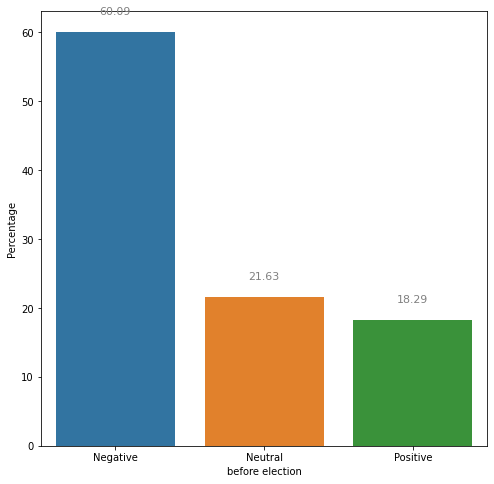

In [ ]:
from matplotlib import pyplot
import seaborn
fig, ax = pyplot.subplots(figsize=(8, 8))
before_plot=before_sentiments.toPandas()
counts = before_plot.label.value_counts(normalize=True) * 100

ax=seaborn.barplot(x=counts.index, y=counts, ax=ax)
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
ax.set_xlabel("before election")

pyplot.show()

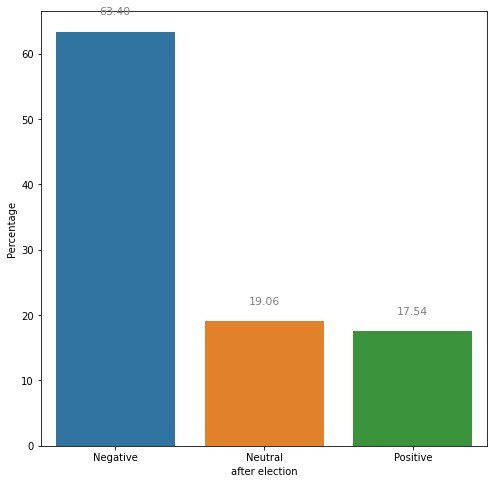

In [ ]:
fig, ax = pyplot.subplots(figsize=(8, 8))
after_plot=after_sentiments.toPandas()
counts = after_plot.label.value_counts(normalize=True) * 100

ax=seaborn.barplot(x=counts.index, y=counts, ax=ax)
#annotate axis = seaborn axis
for p in ax.patches:
  ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
      textcoords='offset points')

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
ax.set_xlabel("after election")

pyplot.show()

In [ ]:
end_time = time.time()
print("process time: " + str(end_time - start_time))

process time: 62.076056718826294
